In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score,train_test_split,StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [64]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('dark_background')
pd.set_option('display.max_rows', 100)

In [6]:
import pickle
with open('ufc_model', 'rb') as handle:
    ufc_model = pickle.load(handle)

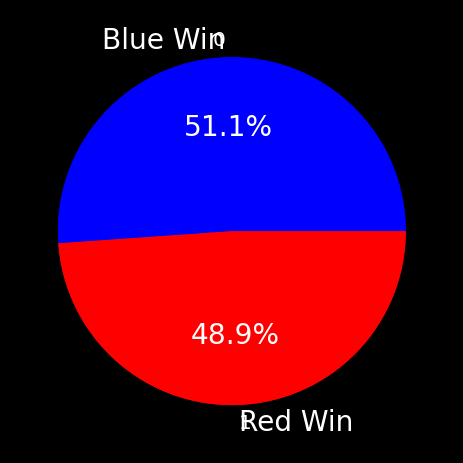

In [19]:
ufc_model.Winner.value_counts(normalize = True).plot(kind = 'pie', colors = ['blue','red'])


df_pie = ufc_model[['Winner','R_fighter','B_fighter']].copy()
df_pie['Winner'] = df_pie['Winner'].apply(lambda x: 'Red Win' if x == 1  else 'Blue Win')
df_pie
df_pie.groupby('Winner').count()['R_fighter'].plot(kind = 'pie',autopct='%1.1f%%', colors = ['blue','red'],fontsize=14)
plt.ylabel('')
plt.savefig('pie2.png', bbox_inches="tight")
#df_pie.plot(kind = 'pie', y = 'Winner')

In [20]:
X = ufc_model.select_dtypes(['number'])
y = X.pop('Winner')

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0,shuffle=True)
SS = StandardScaler()
X_train = SS.fit_transform(X_train)
X_test = SS.transform(X_test)

### Out the box models

In [22]:
def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is not None:
        cols = ['p_'+c for c in labels]
        df = pd.DataFrame(cm, index=labels, columns=cols)
    else:
        cols = ['p_'+str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=cols)
    return df

In [23]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [24]:
models = [KNeighborsClassifier(),
          LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter = 10000),
          DecisionTreeClassifier(),
          SVC(gamma='scale'),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]



X_train = SS.fit_transform(X_train)
X_test = SS.transform(X_test)


res = []

for model in models:
    print(model)
    print()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print('accuracy')
    print(score)
    print('XVal')
    print(cross_val_score(model,X_train, y_train,cv = kf).mean())
    print()
    cm = docm(y_test, y_pred)
    print(cm)
    res.append([model, score])
    print()
    print('-'*60)
    print()

KNeighborsClassifier()

accuracy
0.5343228200371057
XVal
0.5312214986051363

   p_0  p_1
0  315  248
1  254  261

------------------------------------------------------------

LogisticRegression(max_iter=10000, multi_class='ovr')

accuracy
0.5946196660482375
XVal
0.5859604461649623

   p_0  p_1
0  349  214
1  223  292

------------------------------------------------------------

DecisionTreeClassifier()

accuracy
0.5222634508348795
XVal
0.5408161507505468

   p_0  p_1
0  310  253
1  262  253

------------------------------------------------------------

SVC()

accuracy
0.5853432282003711
XVal
0.5884319627143137

   p_0  p_1
0  341  222
1  225  290

------------------------------------------------------------

RandomForestClassifier()

accuracy
0.5584415584415584
XVal
0.5513314607548055

   p_0  p_1
0  342  221
1  255  260

------------------------------------------------------------

ExtraTreesClassifier()

accuracy
0.5788497217068646
XVal
0.5621539757202807

   p_0  p_1
0  357  206
1

<p>We are looking for models with the highest accuracy, the accuracy represents what percentage of fights the model was able to correctly predict the winner of the fight.</p>
<p>In this case, the two best performing models are Logistic regression and Random Forrest which both had accuracies of roughly 70% this is an improvement on the 50% baseline estimation.</p>

In [9]:
## Build a function to compare Hyperparameter Tuned model to base

def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy


### Logistic Regression

<p>We can try and fine-tune our models to increase the accuracy&nbsp;</p>

In [25]:
X_train.shape

(3234, 159)

In [26]:

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train, y_train)))

Accuracy of logistic regression classifier on test set: 0.60
Accuracy of logistic regression classifier on train set: 0.64


C:\Users\jimmy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
## Tune log reg with GS 
gs_params = {'penalty': ['l1', 'l2'],
                   'solver': ['liblinear'],
                   'C': np.logspace(-4, 4, 9)}

model = LogisticRegression()
gs = GridSearchCV(model, gs_params, cv=5, n_jobs=2, verbose=1)
gs.fit(X_train, y_train)
print(gs.best_params_)
print(gs.best_score_)
predictions_train = gs.predict(X_train)
predictions_test = gs.predict(X_test)
best_logreg = gs.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.5970844239428464


In [28]:
print(classification_report(y_train, predictions_train))

              precision    recall  f1-score   support

           0       0.63      0.65      0.64      1641
           1       0.63      0.61      0.62      1593

    accuracy                           0.63      3234
   macro avg       0.63      0.63      0.63      3234
weighted avg       0.63      0.63      0.63      3234



In [29]:
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       0.60      0.62      0.61       563
           1       0.57      0.55      0.56       515

    accuracy                           0.59      1078
   macro avg       0.59      0.58      0.58      1078
weighted avg       0.59      0.59      0.59      1078



<p>precision and recall is roughly the same suggesting that the data is quite balanced i.e one class is not consistently winning, the tuned model shows a percent increase on the out the out the box model</p>

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

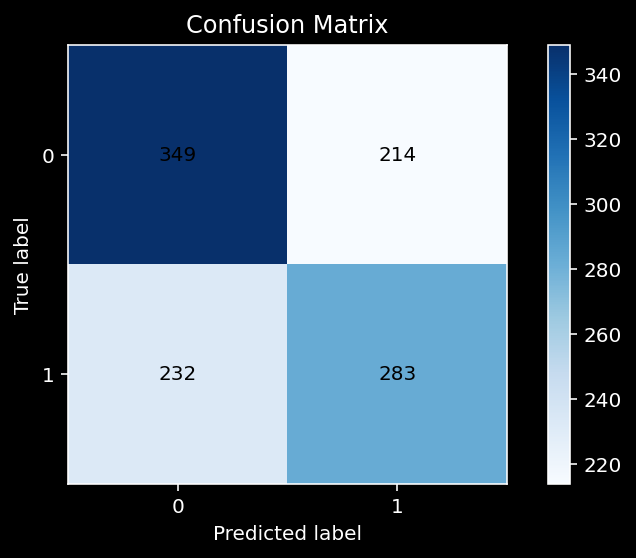

In [31]:
from sklearn.utils.multiclass import unique_labels

cm = confusion_matrix(y_test, predictions_test)
classes = unique_labels(y_test, predictions_test)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')
# Loop over data dimensions and create text annotations.
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="black" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.savefig('confusion matrix')
ax

<p>Below is a list of feature importance ranked by the impact on the target (in this case who will win the fight)&nbsp;</p>
<p>The x labelled features represent the Red Corner, the model is predicting if the X fighter will win which produces a 1 in the winner columm. The key indicators are landed head shots and knockdowns, </p>
<p>&nbsp;</p>

In [66]:
df.sort_values(by='coef', ascending=False) 

,feature,coef
148,age_y,0.264823
11,Fight_type_Women's Flyweight,0.206001
66,Fight_type_wins_Women's Flyweight_x,0.203910
147,age_x,0.197274
24,average_TD_attempted_x,0.165909
102,wins_y,0.141173
79,average_TD_pct_y,0.137803
19,average_SIG_STR_landed_x,0.135416
36,average_GROUND_attempted_x,0.128767
146,Reach_y,0.123508


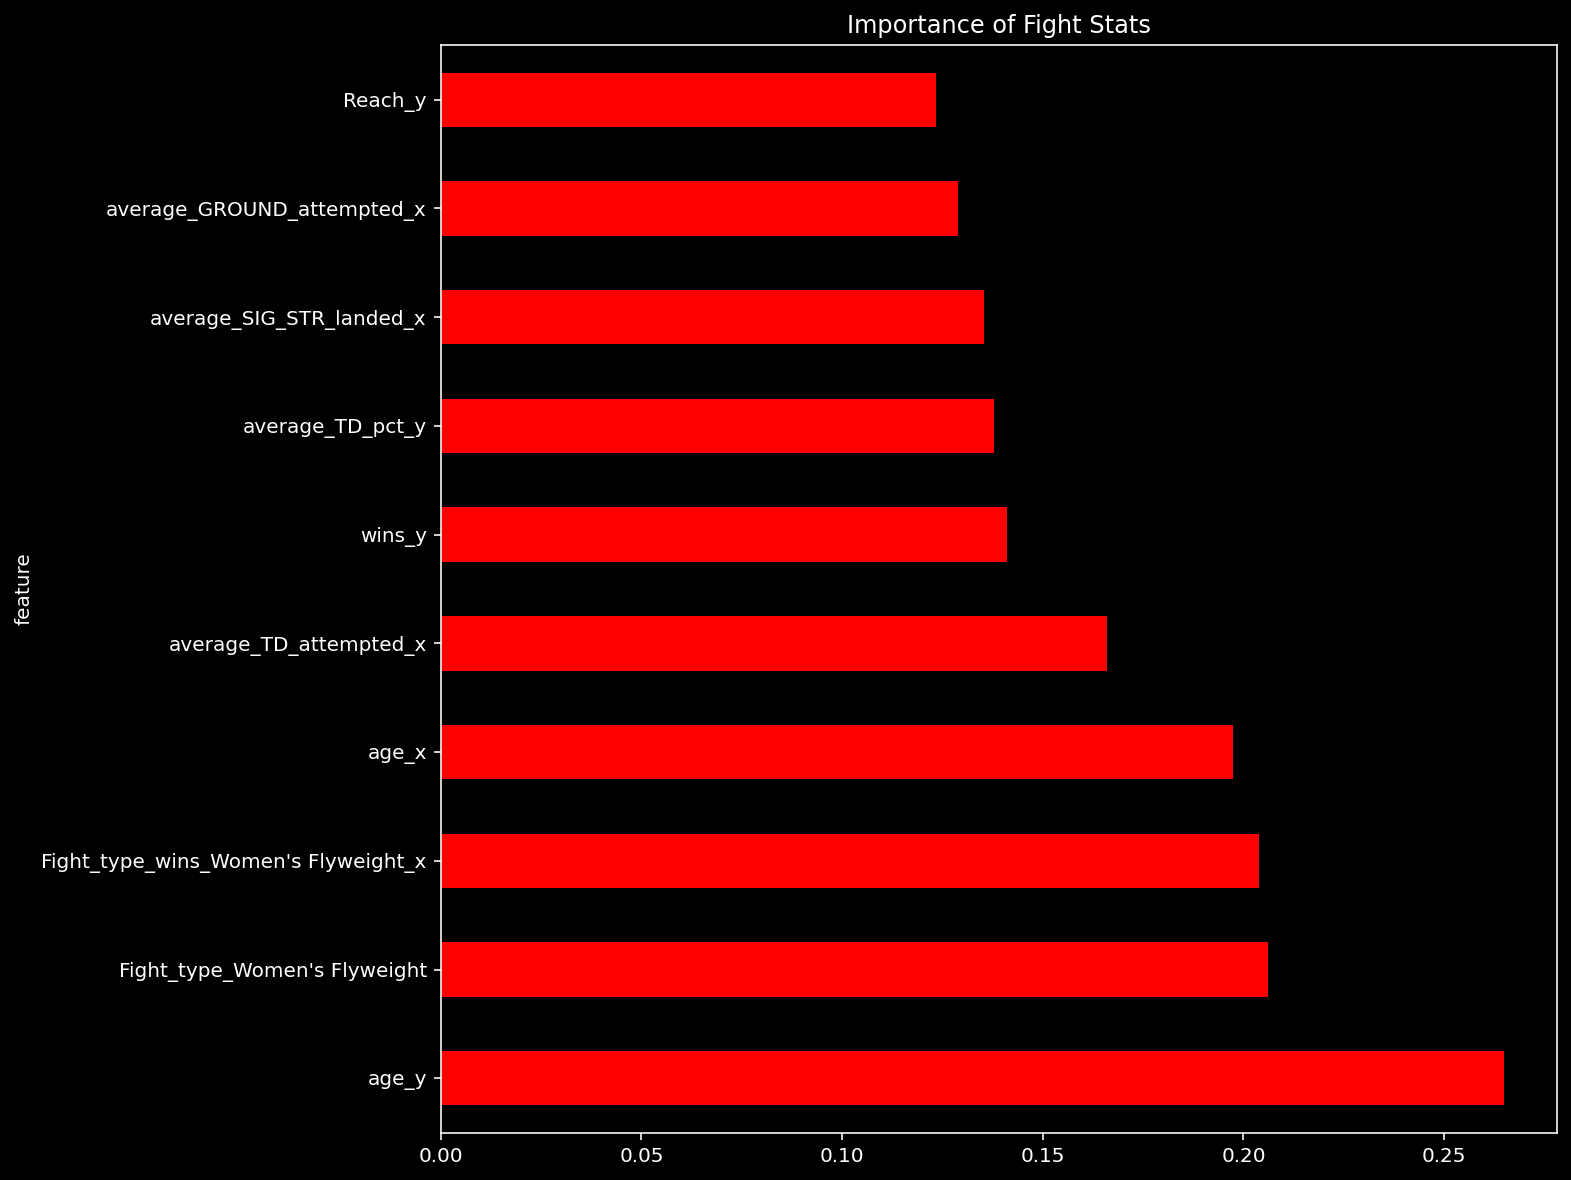

In [69]:



df = pd.DataFrame(list(zip(X.columns, best_logreg.coef_[0])), 
             columns=['feature', 'coef'])
df['coef'] =  df.coef.apply(lambda x : abs(x))
df = df.sort_values(by='coef', ascending=False).head(10)


df.plot(kind='barh', x='feature', y='coef', figsize=(10, 10), color = 'red', legend = False)
plt.title('Importance of Fight Stats')
plt.savefig('coeffs', bbox_inches="tight")
plt.show()

In [49]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(lr, open(filename, 'wb'))

NameError: name 'lr' is not defined

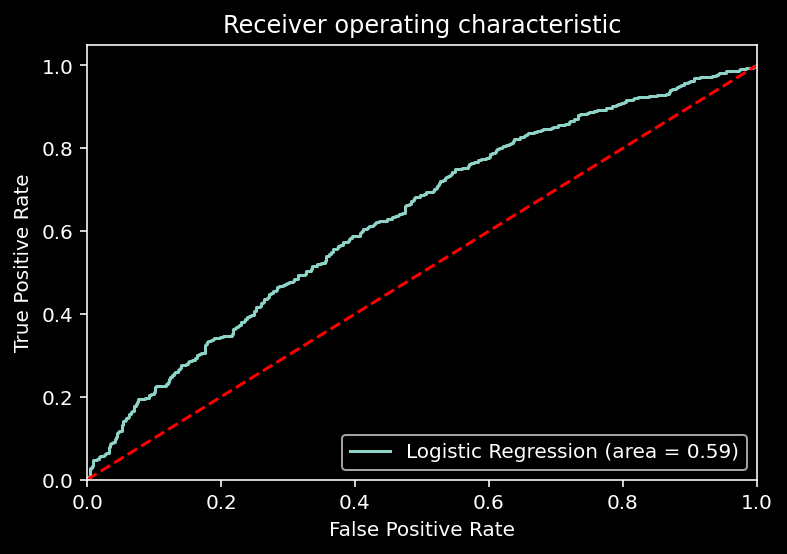

In [71]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC',bbox_inches="tight")
plt.show()

## Random Forrest

### Grid Search

In [46]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)



In [47]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
pp.pprint(grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)


Fitting 3 folds for each of 288 candidates, totalling 864 fits


NameError: name 'pp' is not defined

In [72]:
best_grid.score(X_test, y_test)

0.7003710575139147

In [45]:
# Extract the best decision forest 
y_pred = best_grid.predict(X_test)

# Create a confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Create heatmap from the confusion matrix
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

NameError: name 'best_grid' is not defined

In [73]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    print(mape)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

#### Model Performance

In [70]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of nan%.


C:\Users\jimmy\AppData\Local\Temp/ipykernel_13928/2401553293.py:1: RuntimeWarning: invalid value encountered in double_scalars
  print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


### Random Search

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())


In [47]:
from sklearn.model_selection import RandomizedSearchCV
import pprint
pp = pprint.PrettyPrinter(indent=4)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pp.pprint(random_grid) 



{   'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [48]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [58]:


base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)


best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)


print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.3506 degrees.
Accuracy = -inf%.
Model Performance
Average Error: 0.2848 degrees.
Accuracy = -inf%.
Improvement of nan%.


C:\Users\jimmy\AppData\Local\Temp/ipykernel_13928/3084452175.py:30: RuntimeWarning: invalid value encountered in double_scalars
  print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


## Best Model

##### Using the best Logistic Regression model to apply to all data 

In [36]:
lr = LogisticRegression(C =  0.1, penalty = 'l1', solver = 'liblinear')
X_all = ufc_model.select_dtypes(['number'])
y_all  = X_all.pop('Winner')
lr.fit(X_all,y_all)


LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [38]:
# Extract the predicted
y_pred = lr.predict(X_all)

In [39]:
print(classification_report(y_all, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.66      0.64      2204
           1       0.62      0.59      0.60      2108

    accuracy                           0.62      4312
   macro avg       0.62      0.62      0.62      4312
weighted avg       0.62      0.62      0.62      4312



In [40]:
X.columns

Index(['Title', 'Fight_type_Bantamweight', 'Fight_type_Featherweight',
       'Fight_type_Flyweight', 'Fight_type_Heavyweight',
       'Fight_type_Light Heavyweight', 'Fight_type_Lightweight',
       'Fight_type_Middleweight', 'Fight_type_Open Weight',
       'Fight_type_Welterweight',
       ...
       'Stance_y_Open Stance', 'Stance_y_Orthodox', 'Stance_y_Sideways',
       'Stance_y_Southpaw', 'Stance_y_Switch', 'Stance_x_Open Stance',
       'Stance_x_Orthodox', 'Stance_x_Sideways', 'Stance_x_Southpaw',
       'Stance_x_Switch'],
      dtype='object', length=159)

([<matplotlib.axis.YTick at 0x27d678426d0>,
 [Text(0, 0.5, 'False'), Text(0, 1.5, 'True')])

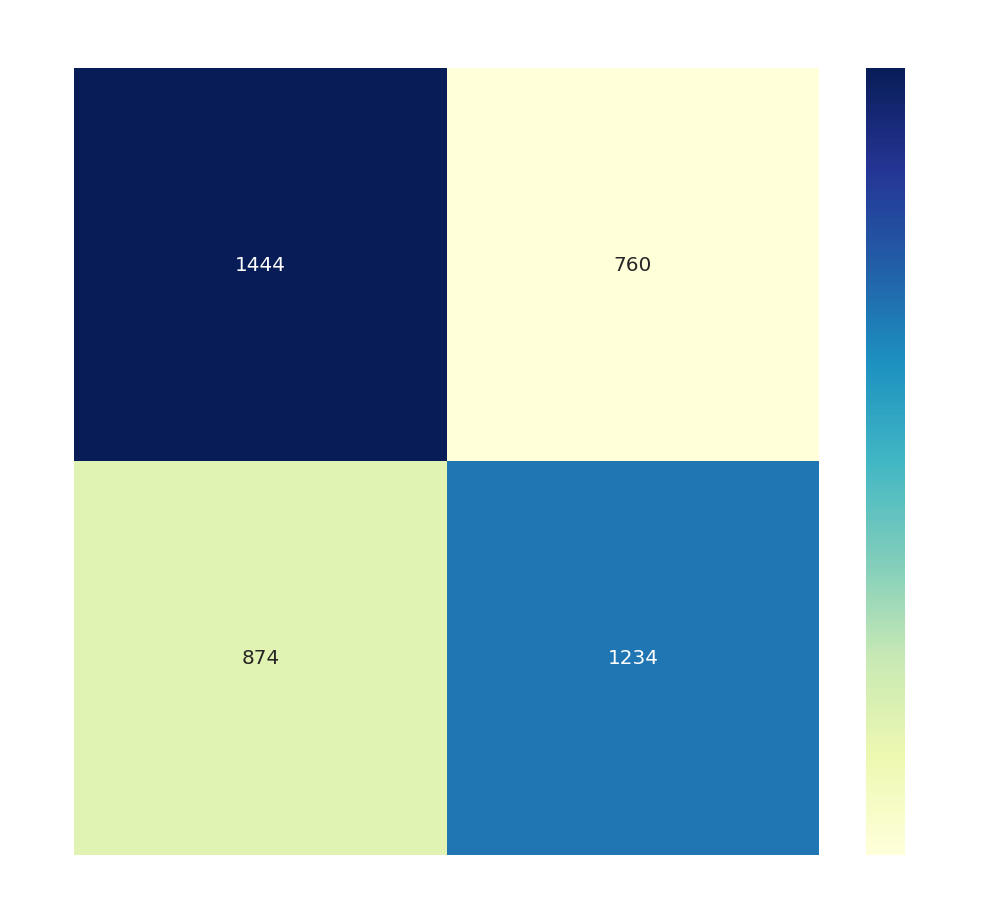

In [41]:
# Create a confusion matrix
cnf_matrix = confusion_matrix(y_all, y_pred)

# Create heatmap from the confusion matrix
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

### Better at predicting Blue win  than Red win

In [42]:
import pickle

with open("Xcol", "wb") as fp:   #Pickling
    pickle.dump(X.columns, fp)

In [43]:
filename = 'finalized_model.sav'
pickle.dump(lr, open(filename, 'wb'))
 